# Complete Optional Parts Implementation
## Neural and Evolutionary Computation - Activity 01

This notebook implements all three optional parts:
1. **Optional Part 1**: Regularization Techniques (L1, L2, Dropout, Combined)
2. **Optional Part 2**: K-Fold Cross Validation (5-fold)
3. **Optional Part 3**: Ensemble Learning Methods (Random Forest, Gradient Boosting, Bagging, AdaBoost)

## Setup: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

import torch
import torch.nn as nn
import torch.optim as optim

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)


Libraries imported successfully!


## Data Loading and Preprocessing

In [ ]:
print("="*80)
print("LOADING AND PREPROCESSING DATA")
print("="*80)

train_data = pd.read_csv('AmesHousing_train.csv')
test_data = pd.read_csv('AmesHousing_test.csv')

print(f"Train set shape: {train_data.shape}")
print(f"Test set shape: {test_data.shape}")

# Remove non-numeric columns
object_cols = train_data.select_dtypes(include=['object']).columns.tolist()
if 'SalePrice' in object_cols:
    object_cols.remove('SalePrice')

if len(object_cols) > 0:
    print(f"\nRemoving {len(object_cols)} non-numeric columns: {object_cols}")
    train_data = train_data.drop(columns=object_cols)
    test_data = test_data.drop(columns=object_cols)

# Separate features and target - FORCE float32
X_train = train_data.drop('SalePrice', axis=1).values.astype(np.float32)
y_train = train_data['SalePrice'].values.astype(np.float32)
X_test = test_data.drop('SalePrice', axis=1).values.astype(np.float32)
y_test = test_data['SalePrice'].values.astype(np.float32)

# Clean NaN/Inf
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

print(f"\nData ready:")
print(f"  Features: {X_train.shape[1]}")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")

LOADING AND PREPROCESSING DATA
Train set shape: (2344, 199)
Test set shape: (586, 199)

Removing 5 non-numeric columns: ['Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond']

Data ready:
  Features: 193
  Training samples: 2344
  Test samples: 586


In [ ]:
# Normalize target
y_mean = y_train.mean()
y_std = y_train.std()
y_train_norm = (y_train - y_mean) / y_std
y_test_norm = (y_test - y_mean) / y_std

print(f"Target normalization:")
print(f"  Mean: ${y_mean:,.2f}")
print(f"  Std: ${y_std:,.2f}")

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_norm, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_norm, dtype=torch.float32).reshape(-1, 1)


Target normalization:
  Mean: $178,582.22
  Std: $77,108.62

Tensors created successfully!


## Utility Functions

In [ ]:
def compute_metrics(y_true, y_pred, denormalize=True, y_mean=y_mean, y_std=y_std):
    """Compute regression metrics"""
    if denormalize:
        y_true = y_true * y_std + y_mean
        y_pred = y_pred * y_std + y_mean

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-8))) * 100
    r2 = r2_score(y_true, y_pred)

    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

class RegularizedNN(nn.Module):
    """Neural Network with Dropout support"""
    def __init__(self, input_size, hidden_sizes, dropout_rate=0.0, activation='relu'):
        super(RegularizedNN, self).__init__()

        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())

            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))

            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


Utility functions defined!


---
# Optional Part 1: Regularization Techniques

Testing different regularization methods:
- **Baseline**: No regularization
- **L2 (Weight Decay)**: Penalizes large weights
- **L1 (Lasso)**: Promotes sparsity
- **Dropout**: Random neuron deactivation
- **Combined**: L2 + Dropout

In [ ]:
print("="*90)
print("OPTIONAL PART 1: REGULARIZATION TECHNIQUES")
print("="*90)

epochs = 200
all_results = []
criterion = nn.MSELoss()

OPTIONAL PART 1: REGULARIZATION TECHNIQUES


## 1.1 Baseline (No Regularization)

In [ ]:
print("\n1. BASELINE (No Regularization)")
model = RegularizedNN(X_train.shape[1], [128, 64, 32])
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 50 == 0:
        print(f"  Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy().flatten()
    y_true = y_test_tensor.numpy().flatten()

metrics_baseline = compute_metrics(y_true, y_pred, denormalize=True)
all_results.append({'Method': 'Baseline', **metrics_baseline})
print(f"  MSE: {metrics_baseline['MSE']:.2f}, R2: {metrics_baseline['R2']:.4f}")


1. BASELINE (No Regularization)
  Epoch 50/200, Loss: 0.171618
  Epoch 100/200, Loss: 0.077426
  Epoch 150/200, Loss: 0.064792
  Epoch 200/200, Loss: 0.039823
  MSE: 862938880.00, R2: 0.8924


## 1.2 L2 Regularization (Weight Decay)

In [ ]:
print("\n2. L2 REGULARIZATION")
l2_lambdas = [0.0001, 0.001, 0.01, 0.1]
l2_results = []

for l2 in l2_lambdas:
    model = RegularizedNN(X_train.shape[1], [128, 64, 32])
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=l2)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).numpy().flatten()

    metrics = compute_metrics(y_true, y_pred, denormalize=True)
    l2_results.append({'Lambda': l2, **metrics})
    print(f"  L2={l2}: MSE={metrics['MSE']:.2f}, R2={metrics['R2']:.4f}")

best_l2_idx = min(range(len(l2_results)), key=lambda i: l2_results[i]['MSE'])
best_l2_lambda = l2_results[best_l2_idx]['Lambda']
all_results.append({'Method': f'L2 (lambda={best_l2_lambda})', **{k: v for k, v in l2_results[best_l2_idx].items() if k != 'Lambda'}})
print(f"\nBest L2 lambda: {best_l2_lambda}")


2. L2 REGULARIZATION
  L2=0.0001: MSE=977027776.00, R2=0.8781
  L2=0.001: MSE=1277225344.00, R2=0.8407
  L2=0.01: MSE=884887680.00, R2=0.8896
  L2=0.1: MSE=1147999488.00, R2=0.8568

Best L2 lambda: 0.01


## 1.3 Dropout Regularization

In [ ]:
print("\n3. DROPOUT REGULARIZATION")
dropout_rates = [0.1, 0.2, 0.3, 0.5]
dropout_results = []

for rate in dropout_rates:
    model = RegularizedNN(X_train.shape[1], [128, 64, 32], dropout_rate=rate)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).numpy().flatten()

    metrics = compute_metrics(y_true, y_pred, denormalize=True)
    dropout_results.append({'Rate': rate, **metrics})
    print(f"  Dropout={rate}: MSE={metrics['MSE']:.2f}, R2={metrics['R2']:.4f}")

best_dropout_idx = min(range(len(dropout_results)), key=lambda i: dropout_results[i]['MSE'])
best_dropout_rate = dropout_results[best_dropout_idx]['Rate']
all_results.append({'Method': f'Dropout (rate={best_dropout_rate})', **{k: v for k, v in dropout_results[best_dropout_idx].items() if k != 'Rate'}})
print(f"\nBest Dropout rate: {best_dropout_rate}")


3. DROPOUT REGULARIZATION
  Dropout=0.1: MSE=974173056.00, R2=0.8785
  Dropout=0.2: MSE=1106109184.00, R2=0.8620
  Dropout=0.3: MSE=1222761472.00, R2=0.8475
  Dropout=0.5: MSE=2395310080.00, R2=0.7012

Best Dropout rate: 0.1


## 1.4 Combined Regularization (L2 + Dropout)

In [ ]:
print("\n4. COMBINED (L2 + Dropout)")
model = RegularizedNN(X_train.shape[1], [128, 64, 32], dropout_rate=best_dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=best_l2_lambda)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy().flatten()

metrics_combined = compute_metrics(y_true, y_pred, denormalize=True)
all_results.append({'Method': 'Combined (L2+Dropout)', **metrics_combined})
print(f"  MSE: {metrics_combined['MSE']:.2f}, R2: {metrics_combined['R2']:.4f}")


4. COMBINED (L2 + Dropout)
  MSE: 1016136576.00, R2: 0.8733


## 1.5 Regularization Results Summary

In [ ]:
df_reg = pd.DataFrame(all_results)
df_reg.to_csv('optional_part1_regularization_comparison.csv', index=False)

print("\n" + "="*80)
print("REGULARIZATION RESULTS:")
print("="*80)
print(df_reg.to_string(index=False))
print("="*80)

best_idx = df_reg['MSE'].idxmin()
print(f"\nBest Method: {df_reg.loc[best_idx, 'Method']}")
print(f"  MSE: {df_reg.loc[best_idx, 'MSE']:.2f}")
print(f"  R2: {df_reg.loc[best_idx, 'R2']:.4f}")


REGULARIZATION RESULTS:
               Method          MSE         RMSE          MAE      MAPE       R2
             Baseline  862938880.0 29375.821350 15063.361328  8.515540 0.892369
     L2 (lambda=0.01)  884887680.0 29747.061704 15737.422852  8.785074 0.889631
   Dropout (rate=0.1)  974173056.0 31211.745481 16527.980469  9.508357 0.878495
Combined (L2+Dropout) 1016136576.0 31876.897214 17183.802734 10.019818 0.873261

Best Method: Baseline
  MSE: 862938880.00
  R2: 0.8924


---
# Optional Part 2: K-Fold Cross Validation

## Objective
Implement k-fold cross-validation to improve model evaluation and selection.

**Parameters:**
- Number of folds: 5
- Strategy: K-Fold with shuffle
- Models tested: Baseline, L2, Dropout, Combined

In [ ]:
print("="*90)
print("OPTIONAL PART 2: K-FOLD CROSS VALIDATION")
print("="*90)

# Configure K-Fold
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Model configurations to test
configs = [
    {'name': 'Baseline', 'dropout': 0.0, 'weight_decay': 0.0},
    {'name': 'L2', 'dropout': 0.0, 'weight_decay': best_l2_lambda},
    {'name': 'Dropout', 'dropout': best_dropout_rate, 'weight_decay': 0.0},
    {'name': 'Combined', 'dropout': best_dropout_rate, 'weight_decay': best_l2_lambda}
]

print(f"\nTesting {len(configs)} model configurations with {k_folds}-fold cross-validation...")
print(f"Best L2 lambda: {best_l2_lambda}")
print(f"Best Dropout rate: {best_dropout_rate}")

OPTIONAL PART 2: K-FOLD CROSS VALIDATION

Testing 4 model configurations with 5-fold cross-validation...
Best L2 lambda: 0.01
Best Dropout rate: 0.1


## 2.1 Cross-Validation Loop

In [ ]:
cv_results = []
epochs_cv = 150  # Reduced epochs for cross-validation

for config in configs:
    print(f"\n{'='*70}")
    print(f"Testing {config['name']} configuration")
    print(f"{'='*70}")
    
    fold_mse = []
    fold_mae = []
    fold_mape = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train), 1):
        # Split data for this fold
        X_fold_train = torch.tensor(X_train[train_idx], dtype=torch.float32)
        y_fold_train = torch.tensor(y_train_norm[train_idx], dtype=torch.float32).reshape(-1, 1)
        X_fold_val = torch.tensor(X_train[val_idx], dtype=torch.float32)
        y_fold_val = torch.tensor(y_train_norm[val_idx], dtype=torch.float32).reshape(-1, 1)
        
        # Create model
        model = RegularizedNN(X_train.shape[1], [128, 64, 32], 
                            dropout_rate=config['dropout'])
        optimizer = optim.Adam(model.parameters(), lr=0.001, 
                             weight_decay=config['weight_decay'])
        
        # Train
        for epoch in range(epochs_cv):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_fold_train)
            loss = criterion(outputs, y_fold_train)
            loss.backward()
            optimizer.step()
        
        # Evaluate on validation fold
        model.eval()
        with torch.no_grad():
            y_pred = model(X_fold_val).numpy().flatten()
            y_val_true = y_fold_val.numpy().flatten()
        
        # Compute metrics (denormalize)
        metrics = compute_metrics(y_val_true, y_pred, denormalize=True)
        fold_mse.append(metrics['MSE'])
        fold_mae.append(metrics['MAE'])
        fold_mape.append(metrics['MAPE'])
        
        print(f"  Fold {fold}/{k_folds} - MSE: {metrics['MSE']:.2f}, MAE: {metrics['MAE']:.2f}")
    
    # Compute mean and std across folds
    cv_results.append({
        'Configuration': config['name'],
        'MSE_mean': np.mean(fold_mse),
        'MSE_std': np.std(fold_mse),
        'MAE_mean': np.mean(fold_mae),
        'MAE_std': np.std(fold_mae),
        'MAPE_mean': np.mean(fold_mape),
        'MAPE_std': np.std(fold_mape)
    })
    
    print(f"\n  Summary for {config['name']}:")
    print(f"    MSE:  {np.mean(fold_mse):.2f} +/- {np.std(fold_mse):.2f}")
    print(f"    MAE:  {np.mean(fold_mae):.2f} +/- {np.std(fold_mae):.2f}")
    print(f"    MAPE: {np.mean(fold_mape):.2f}% +/- {np.std(fold_mape):.2f}%")


Testing Baseline configuration
  Fold 1/5 - MSE: 428234176.00, MAE: 14476.56
  Fold 2/5 - MSE: 867313344.00, MAE: 16194.43
  Fold 3/5 - MSE: 1183617408.00, MAE: 17356.87
  Fold 4/5 - MSE: 540434560.00, MAE: 15073.80
  Fold 5/5 - MSE: 2426976000.00, MAE: 18066.63

  Summary for Baseline:
    MSE:  1089315097.60 +/- 719140073.09
    MAE:  16233.66 +/- 1345.78
    MAPE: 10.13% +/- 1.19%

Testing L2 configuration
  Fold 1/5 - MSE: 489461760.00, MAE: 15445.02
  Fold 2/5 - MSE: 901116480.00, MAE: 16645.32
  Fold 3/5 - MSE: 1162791680.00, MAE: 17375.34
  Fold 4/5 - MSE: 511207424.00, MAE: 15100.49
  Fold 5/5 - MSE: 2433583616.00, MAE: 19504.95

  Summary for L2:
    MSE:  1099632192.00 +/- 712934172.85
    MAE:  16814.22 +/- 1574.48
    MAPE: 10.89% +/- 1.77%

Testing Dropout configuration
  Fold 1/5 - MSE: 544542400.00, MAE: 16049.19
  Fold 2/5 - MSE: 1014742656.00, MAE: 17923.62
  Fold 3/5 - MSE: 1461873152.00, MAE: 20565.57
  Fold 4/5 - MSE: 721453184.00, MAE: 15891.70
  Fold 5/5 - MSE: 2

## 2.2 Cross-Validation Results

In [ ]:
df_cv = pd.DataFrame(cv_results)
df_cv.to_csv('optional_part2_cross_validation_results.csv', index=False)

print("\n" + "="*80)
print("CROSS-VALIDATION RESULTS (5-Fold)")
print("="*80)
print(df_cv.to_string(index=False))
print("="*80)

# Find best configuration
best_idx = df_cv['MSE_mean'].idxmin()
print(f"\nBest Configuration: {df_cv.loc[best_idx, 'Configuration']}")
print(f"  MSE: {df_cv.loc[best_idx, 'MSE_mean']:.2f} +/- {df_cv.loc[best_idx, 'MSE_std']:.2f}")
print(f"  MAE: {df_cv.loc[best_idx, 'MAE_mean']:.2f} +/- {df_cv.loc[best_idx, 'MAE_std']:.2f}")


CROSS-VALIDATION RESULTS (5-Fold)
Configuration     MSE_mean      MSE_std     MAE_mean     MAE_std  MAPE_mean  MAPE_std
     Baseline 1089315097.6 7.191401e+08 16233.659375 1345.778793  10.132390  1.188221
           L2 1099632192.0 7.129342e+08 16814.224219 1574.482129  10.894177  1.769502
      Dropout 1182683737.6 5.835233e+08 17989.171289 1851.245738  11.483624  1.491877
     Combined 1175752896.0 4.298945e+08 19274.728516 1412.894041  12.849386  1.576759

Best Configuration: Baseline
  MSE: 1089315097.60 +/- 719140073.09
  MAE: 16233.66 +/- 1345.78


## 2.3 Stability Analysis

Lower standard deviation indicates better generalization across different data splits.


STABILITY ANALYSIS (Lower std = Better Generalization)

Ranking by MSE Stability:
  Combined     - std: 429894463.39, mean: 1175752896.00
  Dropout      - std: 583523280.25, mean: 1182683737.60
  L2           - std: 712934172.85, mean: 1099632192.00
  Baseline     - std: 719140073.09, mean: 1089315097.60

Most stable configuration: Combined
  MSE std: 429894463.39

Visualization saved: optional_part2_cross_validation_analysis.png


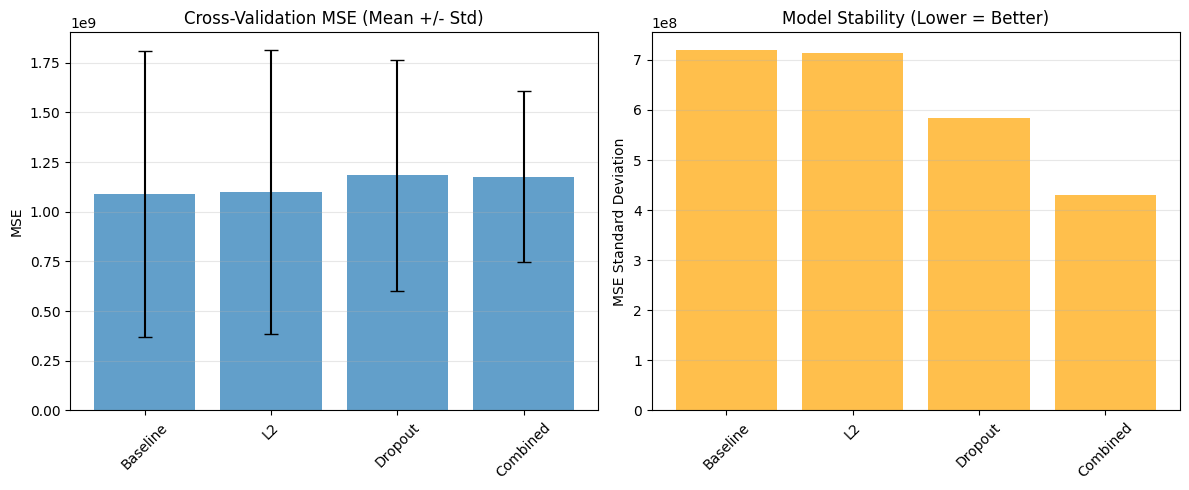

In [ ]:
print("\n" + "="*80)
print("STABILITY ANALYSIS (Lower std = Better Generalization)")
print("="*80)

# Rank by stability (lowest MSE std)
df_cv_sorted = df_cv.sort_values('MSE_std')
print("\nRanking by MSE Stability:")
for idx, row in df_cv_sorted.iterrows():
    print(f"  {row['Configuration']:12s} - std: {row['MSE_std']:8.2f}, mean: {row['MSE_mean']:.2f}")

most_stable = df_cv_sorted.iloc[0]['Configuration']
print(f"\nMost stable configuration: {most_stable}")
print(f"  MSE std: {df_cv_sorted.iloc[0]['MSE_std']:.2f}")

# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
x_pos = np.arange(len(df_cv))
plt.bar(x_pos, df_cv['MSE_mean'], yerr=df_cv['MSE_std'], capsize=5, alpha=0.7)
plt.xticks(x_pos, df_cv['Configuration'], rotation=45)
plt.ylabel('MSE')
plt.title('Cross-Validation MSE (Mean +/- Std)')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(x_pos, df_cv['MSE_std'], alpha=0.7, color='orange')
plt.xticks(x_pos, df_cv['Configuration'], rotation=45)
plt.ylabel('MSE Standard Deviation')
plt.title('Model Stability (Lower = Better)')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('optional_part2_cross_validation_analysis.png', dpi=150, bbox_inches='tight')
print("\nVisualization saved: optional_part2_cross_validation_analysis.png")
plt.show()

---
# Optional Part 3: Ensemble Learning Methods

Testing different ensemble methods:
- **Random Forest**: Multiple decision trees with bootstrap
- **Gradient Boosting**: Sequential trees correcting errors
- **Bagging**: Bootstrap aggregating
- **AdaBoost**: Adaptive boosting with weak learners

In [ ]:
print("\n" + "="*90)
print("OPTIONAL PART 3: ENSEMBLE LEARNING METHODS")
print("="*90)

ensemble_results = []


OPTIONAL PART 3: ENSEMBLE LEARNING METHODS


## 3.1 Random Forest

In [ ]:
print("\n1. RANDOM FOREST")
model_rf = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=5,
                                 min_samples_leaf=2, max_features='sqrt',
                                 random_state=42, n_jobs=-1)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
metrics_rf = compute_metrics(y_test, y_pred_rf, denormalize=False)
ensemble_results.append({'Model': 'Random Forest', **metrics_rf})
print(f"  MSE: {metrics_rf['MSE']:.2f}, R2: {metrics_rf['R2']:.4f}")


1. RANDOM FOREST
  MSE: 778921507.82, R2: 0.9028


## 3.2 Gradient Boosting

In [ ]:
print("\n2. GRADIENT BOOSTING")
model_gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5,
                                     subsample=0.8, min_samples_split=5, random_state=42)
model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_test)
metrics_gb = compute_metrics(y_test, y_pred_gb, denormalize=False)
ensemble_results.append({'Model': 'Gradient Boosting', **metrics_gb})
print(f"  MSE: {metrics_gb['MSE']:.2f}, R2: {metrics_gb['R2']:.4f}")


2. GRADIENT BOOSTING
  MSE: 723331012.62, R2: 0.9098


## 3.3 Bagging Regressor

In [ ]:
print("\n3. BAGGING")
model_bag = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=15, random_state=42),
                             n_estimators=50, max_samples=0.8, max_features=0.8,
                             random_state=42, n_jobs=-1)
model_bag.fit(X_train, y_train)
y_pred_bag = model_bag.predict(X_test)
metrics_bag = compute_metrics(y_test, y_pred_bag, denormalize=False)
ensemble_results.append({'Model': 'Bagging', **metrics_bag})
print(f"  MSE: {metrics_bag['MSE']:.2f}, R2: {metrics_bag['R2']:.4f}")


3. BAGGING
  MSE: 710402516.61, R2: 0.9114


## 3.4 AdaBoost

In [ ]:
print("\n4. ADABOOST")
model_ada = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=4, random_state=42),
                              n_estimators=100, learning_rate=0.8, random_state=42)
model_ada.fit(X_train, y_train)
y_pred_ada = model_ada.predict(X_test)
metrics_ada = compute_metrics(y_test, y_pred_ada, denormalize=False)
ensemble_results.append({'Model': 'AdaBoost', **metrics_ada})
print(f"  MSE: {metrics_ada['MSE']:.2f}, R2: {metrics_ada['R2']:.4f}")


4. ADABOOST
  MSE: 868933405.93, R2: 0.8916


## 3.5 Ensemble Results Summary

In [ ]:
df_ens = pd.DataFrame(ensemble_results)
df_ens.to_csv('optional_part3_ensemble_results.csv', index=False)

print("\n" + "="*80)
print("ENSEMBLE RESULTS:")
print("="*80)
print(df_ens.to_string(index=False))
print("="*80)

best_idx = df_ens['MSE'].idxmin()
print(f"\nBest Model: {df_ens.loc[best_idx, 'Model']}")
print(f"  MSE: {df_ens.loc[best_idx, 'MSE']:.2f}")
print(f"  R2: {df_ens.loc[best_idx, 'R2']:.4f}")


ENSEMBLE RESULTS:
            Model          MSE         RMSE          MAE      MAPE       R2
    Random Forest 7.789215e+08 27909.165301 16067.672428  8.888318 0.902848
Gradient Boosting 7.233310e+08 26894.813861 15008.699554  7.830982 0.909782
          Bagging 7.104025e+08 26653.377208 15647.633720  8.494054 0.911394
         AdaBoost 8.689334e+08 29477.676400 20863.608880 12.509705 0.891621

Best Model: Bagging
  MSE: 710402516.61
  R2: 0.9114
